# BIND Paper Analysis: Density Profile Analysis

This notebook analyzes radial density profiles of BIND-generated halos compared to true hydrodynamic halos.

## Contents
1. [Setup & Imports](#1-setup--imports)
2. [Density Profile Functions](#2-density-profile-functions)
3. [Load Density Profiles](#3-load-density-profiles)
4. [Mean Residual Analysis](#4-mean-residual-analysis)
5. [Channel-wise Analysis](#5-channel-wise-analysis)
6. [Parameter Correlation](#6-parameter-correlation)

---

## Key Quantity: Profile Residual

We compute the fractional residual between BIND and hydro surface density profiles:

$$\text{Residual}(r) = \frac{\Sigma_{\rm BIND}(r)}{\Sigma_{\rm Hydro}(r)} - 1$$

where $\Sigma(r)$ is the projected surface density at radius $r$ (in units of $R_{200c}$).

---

## 1. Setup & Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from scipy.stats import spearmanr

# Local utilities
import sys
sys.path.insert(0, '..')
from paper_notebooks.paper_utils import (
    setup_plotting_style, BOX_SIZE, GRID_SIZE, PIXEL_TO_MPC, MODEL_NAME,
    CHANNEL_NAMES, load_1p_params, load_sb35_metadata, savefig_paper
)

setup_plotting_style()

import os
os.makedirs('paper_plots', exist_ok=True)

# Number of radial bins
NBINS = 21

## 2. Density Profile Functions

In [2]:
def get_projected_surface_density(halo_mass, radius_pix, size=128, nbins=NBINS):
    """
    Calculate projected surface density profile in logarithmic radial bins out to 3×R200.
    
    Parameters
    ----------
    halo_mass : np.ndarray
        2D mass map of halo cutout
    radius_pix : float
        R200 radius in pixels
    size : int
        Cutout size in pixels
    nbins : int
        Number of radial bins
        
    Returns
    -------
    tuple : (surface_densities, bin_centers) where bin_centers are in units of R200
    """
    # Handle 1D input
    if halo_mass.ndim == 1:
        sqrt_size = int(np.sqrt(len(halo_mass)))
        halo_mass = halo_mass.reshape(sqrt_size, sqrt_size)
        size = sqrt_size
    
    if halo_mass.shape[0] != size:
        size = halo_mass.shape[0]
    
    # Radial bins from 0.1×R200 to 3×R200 in log space
    radial_bins = np.logspace(np.log10(0.1), np.log10(3), nbins)
    bin_centers = np.sqrt(radial_bins[:-1] * radial_bins[1:])
    
    # Calculate annular areas in physical units (Mpc²)
    annular_areas = np.pi * (radial_bins[1:]**2 - radial_bins[:-1]**2) * (radius_pix * PIXEL_TO_MPC)**2
    
    # Create distance map from center
    center = size // 2
    y, x = np.ogrid[:size, :size]
    dist = np.sqrt((x - center)**2 + (y - center)**2)
    
    # Calculate surface density in each annular bin
    surface_densities = np.zeros(len(radial_bins) - 1)
    for i in range(len(radial_bins) - 1):
        mask = (dist >= radial_bins[i] * radius_pix) & (dist < radial_bins[i+1] * radius_pix)
        mass = halo_mass[mask]
        if annular_areas[i] > 0 and len(mass) > 0:
            surface_densities[i] = mass.sum() / annular_areas[i]
        else:
            surface_densities[i] = np.nan
    
    return surface_densities, bin_centers


def radius_kpc_to_pixels(radius_kpc):
    """Convert radius from kpc to pixels."""
    return radius_kpc / 1000 * GRID_SIZE / BOX_SIZE

## 3. Load Density Profiles

Load and compute density profiles for all datasets.

In [3]:
def load_profiles_for_dataset(dataset, sim_list, base_path_template):
    """
    Load density profiles for all simulations in a dataset.
    
    For each generated sample in the batch, compute the profile and residual,
    then average across the batch. This avoids Jensen's inequality issues.
    
    Parameters
    ----------
    dataset : str
        Dataset name ('CV', '1P', 'SB35')
    sim_list : list
        List of simulation identifiers
    base_path_template : str
        Path template for simulation data
        
    Returns
    -------
    dict : Dictionary containing hydro_profiles, binded_profiles, radial_bins
    """
    hydro_profiles = []
    binded_profiles = []
    profile_radii = []
    
    for sim_id in sim_list:
        try:
            # Construct paths based on dataset
            if dataset == 'CV':
                basepath = f'/mnt/home/mlee1/ceph/BIND2d_new/CV/sim_{sim_id}/snap_90/mass_threshold_13/'
            elif dataset == '1P':
                basepath = f'/mnt/home/mlee1/ceph/BIND2d_new/1P/{sim_id}/snap_90/mass_threshold_13/'
            elif dataset == 'SB35':
                basepath = f'/mnt/home/mlee1/ceph/BIND2d_new/SB35/sim_{sim_id}/snap_90/mass_threshold_13/'
            
            # Load data
            hydro_cutouts = np.load(basepath + 'hydro_cutouts.npy')
            halo_metadata = np.load(basepath + 'halo_metadata.npz', allow_pickle=True)
            halo_radii = halo_metadata['radii']  # in kpc
            
            gen_data = np.load(basepath + f'{MODEL_NAME}/generated_halos.npz')
            gen_cutouts = gen_data['generated']  # Shape: (n_halos, batch, channels, l, w)
            n_batch = gen_cutouts.shape[1]
            
            # Compute profiles for each halo
            sim_hydro = []
            sim_binded = []
            
            for halo_idx in range(len(hydro_cutouts)):
                hydro_total = hydro_cutouts[halo_idx].sum(axis=0)  # Sum over channels
                radius_pix = radius_kpc_to_pixels(halo_radii[halo_idx])
                
                hydro_profile, bin_centers = get_projected_surface_density(
                    hydro_total, radius_pix, size=128, nbins=NBINS
                )
                sim_hydro.append(hydro_profile)
                
                # Compute profile for each batch sample, then average
                batch_profiles = []
                for b in range(n_batch):
                    binded_total = gen_cutouts[halo_idx, b].sum(axis=0)  # Sum over channels
                    binded_profile, _ = get_projected_surface_density(
                        binded_total, radius_pix, size=128, nbins=NBINS
                    )
                    batch_profiles.append(binded_profile)
                
                # Average profile across batch
                sim_binded.append(np.mean(batch_profiles, axis=0))
            
            hydro_profiles.append(np.array(sim_hydro))
            binded_profiles.append(np.array(sim_binded))
            profile_radii.append(bin_centers)
            
        except Exception as e:
            print(f"Error processing {dataset} sim {sim_id}: {e}")
            continue
    
    return {
        'hydro_profiles': hydro_profiles,
        'binded_profiles': binded_profiles,
        'radial_bins': profile_radii[0] if profile_radii else None
    }

In [4]:
# Load SB35 metadata
sb35_metadata, sb35_minmax, sb35_sim_nums = load_sb35_metadata()

# Load 1P parameter info
oneP_params, names_1p, param_array_1p, fiducial_params = load_1p_params()

In [5]:
# Load profiles for each dataset
print("Loading SB35 profiles...")
sb35_profiles = load_profiles_for_dataset('SB35', sb35_sim_nums, None)
print(f"  Loaded {len(sb35_profiles['hydro_profiles'])} simulations")

print("Loading 1P profiles...")
oneP_profiles = load_profiles_for_dataset('1P', names_1p, None)
print(f"  Loaded {len(oneP_profiles['hydro_profiles'])} simulations")

print("Loading CV profiles...")
cv_sims = [i for i in range(25) if i != 17]
cv_profiles = load_profiles_for_dataset('CV', cv_sims, None)
print(f"  Loaded {len(cv_profiles['hydro_profiles'])} simulations")

# Use first dataset's radii as reference
radial_bins = sb35_profiles['radial_bins']
print(f"\nRadial bins (in units of R200c): {radial_bins}")

Loading SB35 profiles...
Error processing SB35 sim 665: [Errno 2] No such file or directory: '/mnt/home/mlee1/ceph/BIND2d_new/SB35/sim_665/snap_90/mass_threshold_13/clean_vdm_aggressive_stellar_nofocus/generated_halos.npz'
  Loaded 101 simulations
Loading 1P profiles...
  Loaded 140 simulations
Loading CV profiles...
  Loaded 24 simulations

Radial bins (in units of R200c): [0.10887497 0.12905775 0.15298194 0.18134109 0.21495734 0.25480523
 0.30203996 0.35803087 0.42440113 0.50307484 0.59633275 0.70687842
 0.83791658 0.99324605 1.17736985 1.39562575 1.65434101 1.96101582
 2.32454073 2.75545437]


## 4. Mean Residual Analysis

Compute mean and standard deviation of residuals across all halos.

In [6]:
def compute_residuals(profiles_dict):
    """
    Compute residuals (BIND/Hydro - 1) for all halos.
    
    Returns
    -------
    tuple : (all_residuals, mean_residual, std_residual)
    """
    residuals = []
    
    for sim_idx in range(len(profiles_dict['hydro_profiles'])):
        hydro = profiles_dict['hydro_profiles'][sim_idx]
        binded = profiles_dict['binded_profiles'][sim_idx]
        
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = binded / hydro - 1
            residuals.append(ratio)
    
    all_residuals = np.concatenate(residuals, axis=0)
    mean_residual = np.nanmean(all_residuals, axis=0)
    std_residual = np.nanstd(all_residuals, axis=0)
    
    return all_residuals, mean_residual, std_residual

In [7]:
# Compute residuals for each dataset
sb35_residuals, sb35_mean, sb35_std = compute_residuals(sb35_profiles)
oneP_residuals, oneP_mean, oneP_std = compute_residuals(oneP_profiles)
cv_residuals, cv_mean, cv_std = compute_residuals(cv_profiles)

# Find R200 index
r200_idx = np.argmin(np.abs(radial_bins - 1))

print(f"Dataset statistics (at R200c):")
print(f"  SB35: {sb35_residuals.shape[0]} halos, μ = {sb35_mean[r200_idx]:.4f} ± {sb35_std[r200_idx]:.4f}")
print(f"  1P:   {oneP_residuals.shape[0]} halos, μ = {oneP_mean[r200_idx]:.4f} ± {oneP_std[r200_idx]:.4f}")
print(f"  CV:   {cv_residuals.shape[0]} halos, μ = {cv_mean[r200_idx]:.4f} ± {cv_std[r200_idx]:.4f}")

Dataset statistics (at R200c):
  SB35: 4272 halos, μ = 0.0125 ± 0.0703
  1P:   6872 halos, μ = 0.0051 ± 0.0555
  CV:   1030 halos, μ = 0.0034 ± 0.0591


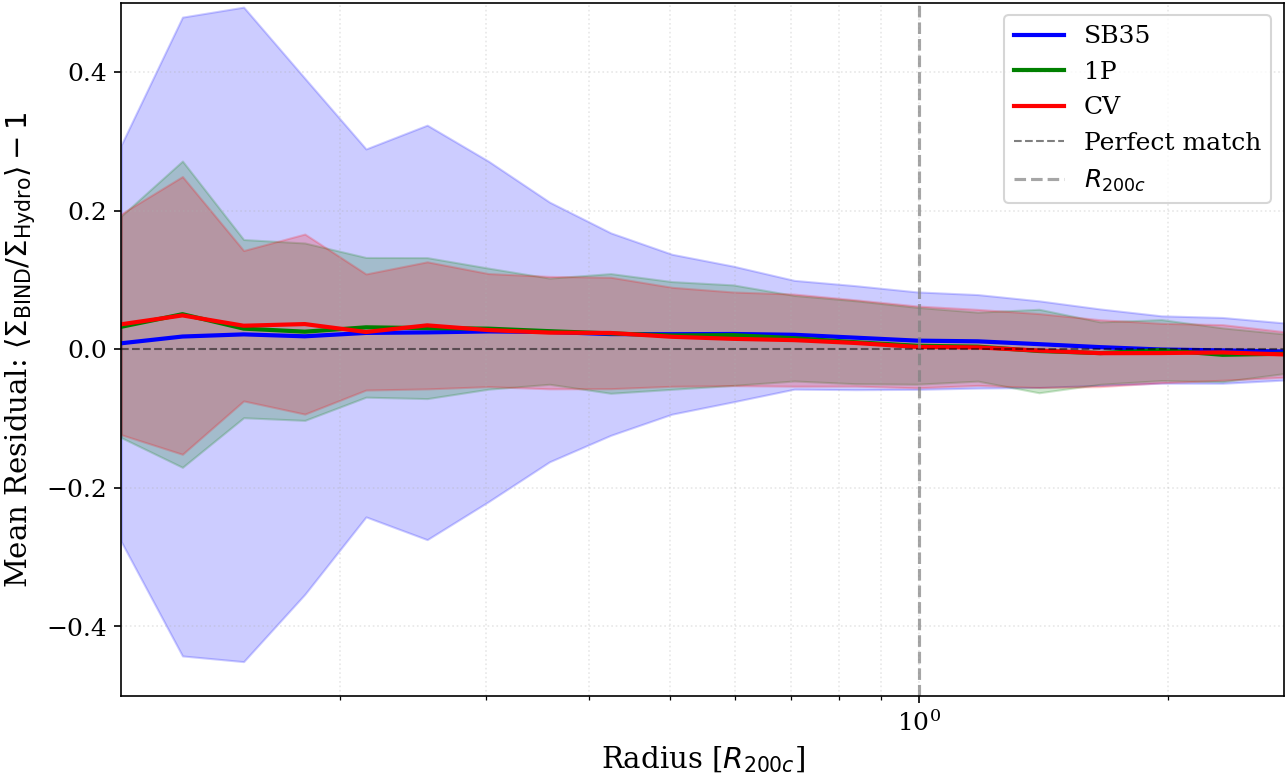

In [8]:
# Figure: Mean residuals comparison across datasets
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

datasets_plot = [
    ('SB35', sb35_mean, sb35_std, 'blue'),
    ('1P', oneP_mean, oneP_std, 'green'),
    ('CV', cv_mean, cv_std, 'red')
]

for name, mean, std, color in datasets_plot:
    ax.semilogx(radial_bins, mean, label=name, color=color, linewidth=2)
    ax.fill_between(radial_bins, mean - std, mean + std, color=color, alpha=0.2)

# Reference lines
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Perfect match')
ax.axvline(1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label=r'$R_{200c}$')

# Formatting
ax.set_xlabel(r'Radius [$R_{200c}$]', fontsize=14)
ax.set_ylabel(r'Mean Residual: $\langle \Sigma_{\rm BIND} / \Sigma_{\rm Hydro} \rangle - 1$', fontsize=14)
ax.set_xlim(radial_bins[0], radial_bins[-1])
ax.set_ylim(-0.5, 0.5)
ax.grid(True, alpha=0.3, which='both', linestyle=':')
ax.legend(fontsize=12)

savefig_paper(fig, 'density_profile_mean_residuals_comparison.pdf')
plt.show()

/tmp/ipykernel_1063212/2676275020.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


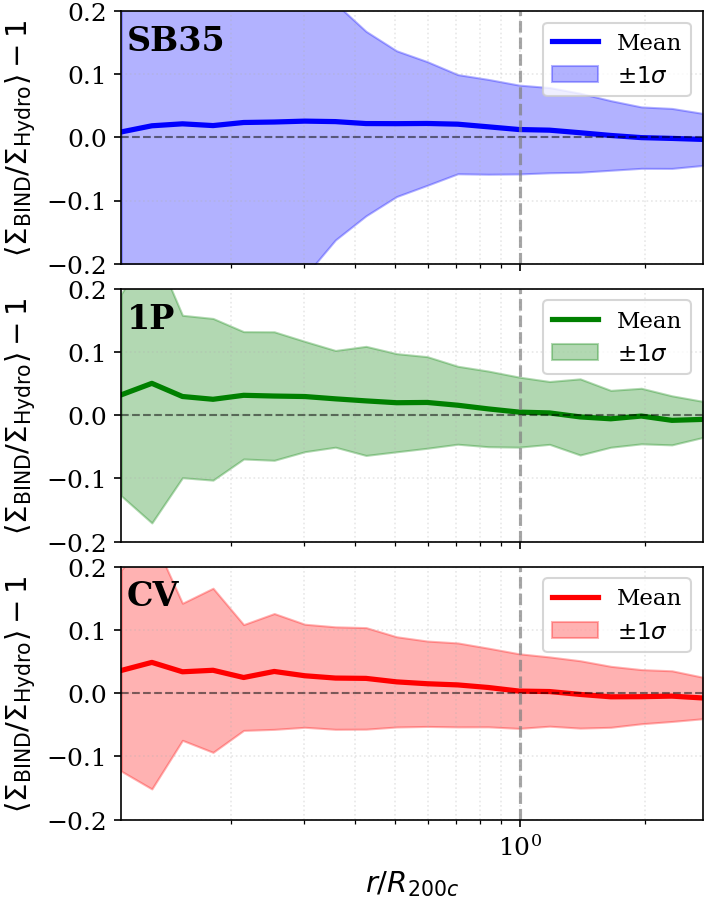

In [9]:
# Figure: Individual dataset panels
fig, axes = plt.subplots(3, 1, figsize=(5, 7), sharey=True, sharex=True, gridspec_kw={'hspace': 0.1})

datasets_plot = [
    ('SB35', sb35_mean, sb35_std, 'blue', sb35_residuals.shape[0]),
    ('1P', oneP_mean, oneP_std, 'green', oneP_residuals.shape[0]),
    ('CV', cv_mean, cv_std, 'red', cv_residuals.shape[0])
]

for ax, (name, mean, std, color, n_halos) in zip(axes, datasets_plot):
    ax.semilogx(radial_bins, mean, color=color, linewidth=2.5, label='Mean')
    ax.fill_between(radial_bins, mean - std, mean + std, color=color, alpha=0.3, label=r'$\pm 1\sigma$')
    
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.axvline(1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.set_ylabel(r'$\langle \Sigma_{\rm BIND} / \Sigma_{\rm Hydro} \rangle - 1$', fontsize=14)
    
    if ax == axes[-1]:
        ax.set_xlabel(r'$r/R_{200c}$', fontsize=14)
    
    ax.text(0.01, 0.95, name, transform=ax.transAxes, fontsize=16, fontweight='bold',
            verticalalignment='top', horizontalalignment='left')
    
    ax.set_xlim(radial_bins[0], radial_bins[-1])
    ax.set_ylim(-0.2, 0.2)
    ax.grid(True, alpha=0.3, which='both', linestyle=':')
    ax.legend(fontsize=11)

plt.tight_layout()
savefig_paper(fig, 'density_profile_mean_residuals_individual.pdf')
plt.show()

## 5. Channel-wise Analysis

Break down residuals by individual channels: hydro_dm, gas, and stars.

In [10]:
def compute_channel_residuals(dataset, sim_list):
    """
    Compute residuals for each channel separately.
    
    For each generated sample in the batch, compute the profile and residual,
    then average across the batch. This avoids Jensen's inequality issues.
    
    Returns
    -------
    dict : {channel_idx: {'mean': array, 'std': array, 'count': int}}
    """
    channel_residuals = {ch: [] for ch in range(3)}
    
    for sim_id in sim_list:
        try:
            if dataset == 'CV':
                basepath = f'/mnt/home/mlee1/ceph/BIND2d_new/CV/sim_{sim_id}/snap_90/mass_threshold_13/'
            elif dataset == '1P':
                basepath = f'/mnt/home/mlee1/ceph/BIND2d_new/1P/{sim_id}/snap_90/mass_threshold_13/'
            elif dataset == 'SB35':
                basepath = f'/mnt/home/mlee1/ceph/BIND2d_new/SB35/sim_{sim_id}/snap_90/mass_threshold_13/'
            
            hydro_cutouts = np.load(basepath + 'hydro_cutouts.npy')
            halo_metadata = np.load(basepath + 'halo_metadata.npz', allow_pickle=True)
            halo_radii = halo_metadata['radii']
            
            gen_data = np.load(basepath + f'{MODEL_NAME}/generated_halos.npz')
            gen_cutouts = gen_data['generated']  # Shape: (n_halos, batch, channels, l, w)
            n_batch = gen_cutouts.shape[1]
            
            for halo_idx in range(len(hydro_cutouts)):
                radius_pix = radius_kpc_to_pixels(halo_radii[halo_idx])
                
                for ch in range(3):
                    hydro_channel = hydro_cutouts[halo_idx, ch]
                    hydro_profile, _ = get_projected_surface_density(hydro_channel, radius_pix)
                    
                    # Compute residual for each batch sample, then average
                    batch_residuals = []
                    for b in range(n_batch):
                        binded_channel = gen_cutouts[halo_idx, b, ch]
                        binded_profile, _ = get_projected_surface_density(binded_channel, radius_pix)
                        
                        with np.errstate(divide='ignore', invalid='ignore'):
                            ratio = binded_profile / hydro_profile - 1
                            batch_residuals.append(ratio)
                    
                    # Average residual across batch
                    channel_residuals[ch].append(np.mean(batch_residuals, axis=0))
                        
        except Exception as e:
            continue
    
    # Compute statistics
    results = {}
    for ch in range(3):
        residuals = np.array(channel_residuals[ch])
        results[ch] = {
            'mean': np.nanmean(residuals, axis=0),
            'std': np.nanstd(residuals, axis=0),
            'count': residuals.shape[0]
        }
    
    return results

In [11]:
# Compute channel residuals for each dataset
print("Computing SB35 channel residuals...")
sb35_channel = compute_channel_residuals('SB35', sb35_sim_nums)

print("Computing 1P channel residuals...")
oneP_channel = compute_channel_residuals('1P', names_1p)

print("Computing CV channel residuals...")
cv_channel = compute_channel_residuals('CV', cv_sims)

Computing SB35 channel residuals...


/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1734: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


Computing 1P channel residuals...
Computing CV channel residuals...


/tmp/ipykernel_1063212/3720616757.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


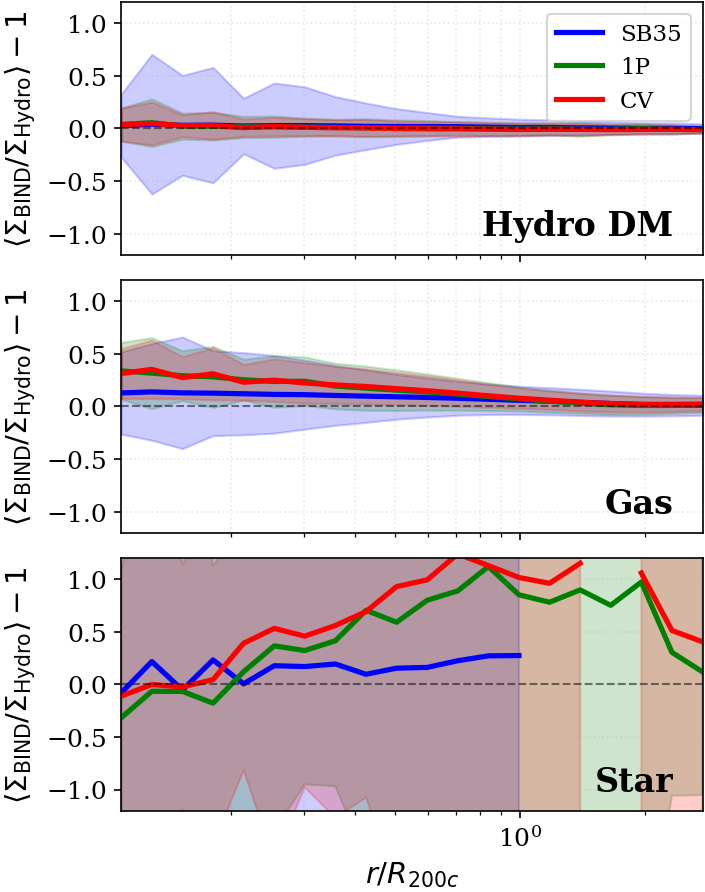

In [12]:
# Figure: Channel-wise residuals by channel
fig, axes = plt.subplots(3, 1, figsize=(5, 7), sharex=True, sharey=True, gridspec_kw={'hspace': 0.1})

colors = {'SB35': 'blue', '1P': 'green', 'CV': 'red'}
datasets_dict = {
    'SB35': sb35_channel,
    '1P': oneP_channel,
    'CV': cv_channel
}

for col, ch in enumerate(range(3)):
    ax = axes[col]
    
    for dataset_name, channel_data in datasets_dict.items():
        mean_res = channel_data[ch]['mean']
        std_res = channel_data[ch]['std']
        color = colors[dataset_name]
        
        ax.semilogx(radial_bins, mean_res, color=color, linewidth=2.5, label=dataset_name)
        ax.fill_between(radial_bins, mean_res - std_res, mean_res + std_res, color=color, alpha=0.2)
    
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_ylabel(r'$\langle \Sigma_{\rm BIND} / \Sigma_{\rm Hydro} \rangle - 1$', fontsize=14)
    
    if col == 2:
        ax.set_xlabel(r'$r/R_{200c}$', fontsize=14)
    
    ax.text(0.95, 0.05, CHANNEL_NAMES[ch], transform=ax.transAxes, fontsize=16, fontweight='bold',
            verticalalignment='bottom', horizontalalignment='right')
    
    ax.set_xlim(radial_bins[0], radial_bins[-1])
    ax.set_ylim(-1.2, 1.2)
    ax.grid(True, alpha=0.3, which='both', linestyle=':')
    
    if col == 0:
        ax.legend(fontsize=11, loc='best')

plt.tight_layout()
savefig_paper(fig, 'density_profile_channel_residuals_by_channel.pdf')
plt.show()

In [13]:
# Print summary statistics
print("\n" + "="*80)
print("SUMMARY: Channel-wise Residuals at R200c")
print("="*80)

for dataset_name, channel_data in datasets_dict.items():
    print(f"\n{dataset_name}:")
    for ch in range(3):
        mean_val = channel_data[ch]['mean'][r200_idx]
        std_val = channel_data[ch]['std'][r200_idx]
        print(f"  {CHANNEL_NAMES[ch]:10s}: μ = {mean_val:+.4f} ± {std_val:.4f}")


SUMMARY: Channel-wise Residuals at R200c

SB35:
  Hydro DM  : μ = +0.0085 ± 0.0789
  Gas       : μ = +0.0572 ± 0.1338
  Star      : μ = +0.2727 ± 2.6468

1P:
  Hydro DM  : μ = -0.0066 ± 0.0583
  Gas       : μ = +0.0705 ± 0.1145
  Star      : μ = +0.8494 ± 2.6185

CV:
  Hydro DM  : μ = -0.0104 ± 0.0621
  Gas       : μ = +0.0775 ± 0.0960
  Star      : μ = +1.0142 ± 4.9659


## 6. Parameter Correlation

Analyze how density profiles correlate with cosmological/astrophysical parameters.

In [14]:
# Load parameter values for SB35
sb35_param_vals = []
for sim_num in sb35_sim_nums[:len(sb35_profiles['hydro_profiles'])]:
    try:
        sb35_param_vals.append(sb35_metadata.loc[sim_num].to_list())
    except:
        continue

sb35_param_vals = np.array(sb35_param_vals)

In [15]:
# Compute Spearman correlations: density vs parameters
bind_correlations = np.zeros((35, len(radial_bins)))
hydro_correlations = np.zeros((35, len(radial_bins)))

for param_idx in range(35):
    param_values = sb35_param_vals[:, param_idx]
    
    for r_idx in range(len(radial_bins)):
        # BIND densities at this radius
        bind_densities = []
        hydro_densities = []
        
        for sim_idx in range(len(sb35_profiles['hydro_profiles'])):
            bind_prof = sb35_profiles['binded_profiles'][sim_idx][:, r_idx]
            hydro_prof = sb35_profiles['hydro_profiles'][sim_idx][:, r_idx]
            
            valid_bind = bind_prof[np.isfinite(bind_prof)]
            valid_hydro = hydro_prof[np.isfinite(hydro_prof)]
            
            if len(valid_bind) > 0:
                bind_densities.append(np.nanmean(valid_bind))
            else:
                bind_densities.append(np.nan)
                
            if len(valid_hydro) > 0:
                hydro_densities.append(np.nanmean(valid_hydro))
            else:
                hydro_densities.append(np.nan)
        
        bind_densities = np.array(bind_densities)
        hydro_densities = np.array(hydro_densities)
        
        # Compute correlations
        valid_mask = np.isfinite(bind_densities) & np.isfinite(param_values)
        if np.sum(valid_mask) > 3:
            corr, _ = spearmanr(param_values[valid_mask], bind_densities[valid_mask])
            bind_correlations[param_idx, r_idx] = corr
        
        valid_mask = np.isfinite(hydro_densities) & np.isfinite(param_values)
        if np.sum(valid_mask) > 3:
            corr, _ = spearmanr(param_values[valid_mask], hydro_densities[valid_mask])
            hydro_correlations[param_idx, r_idx] = corr

print(f"Computed correlation matrices: {bind_correlations.shape}")

Computed correlation matrices: (35, 20)


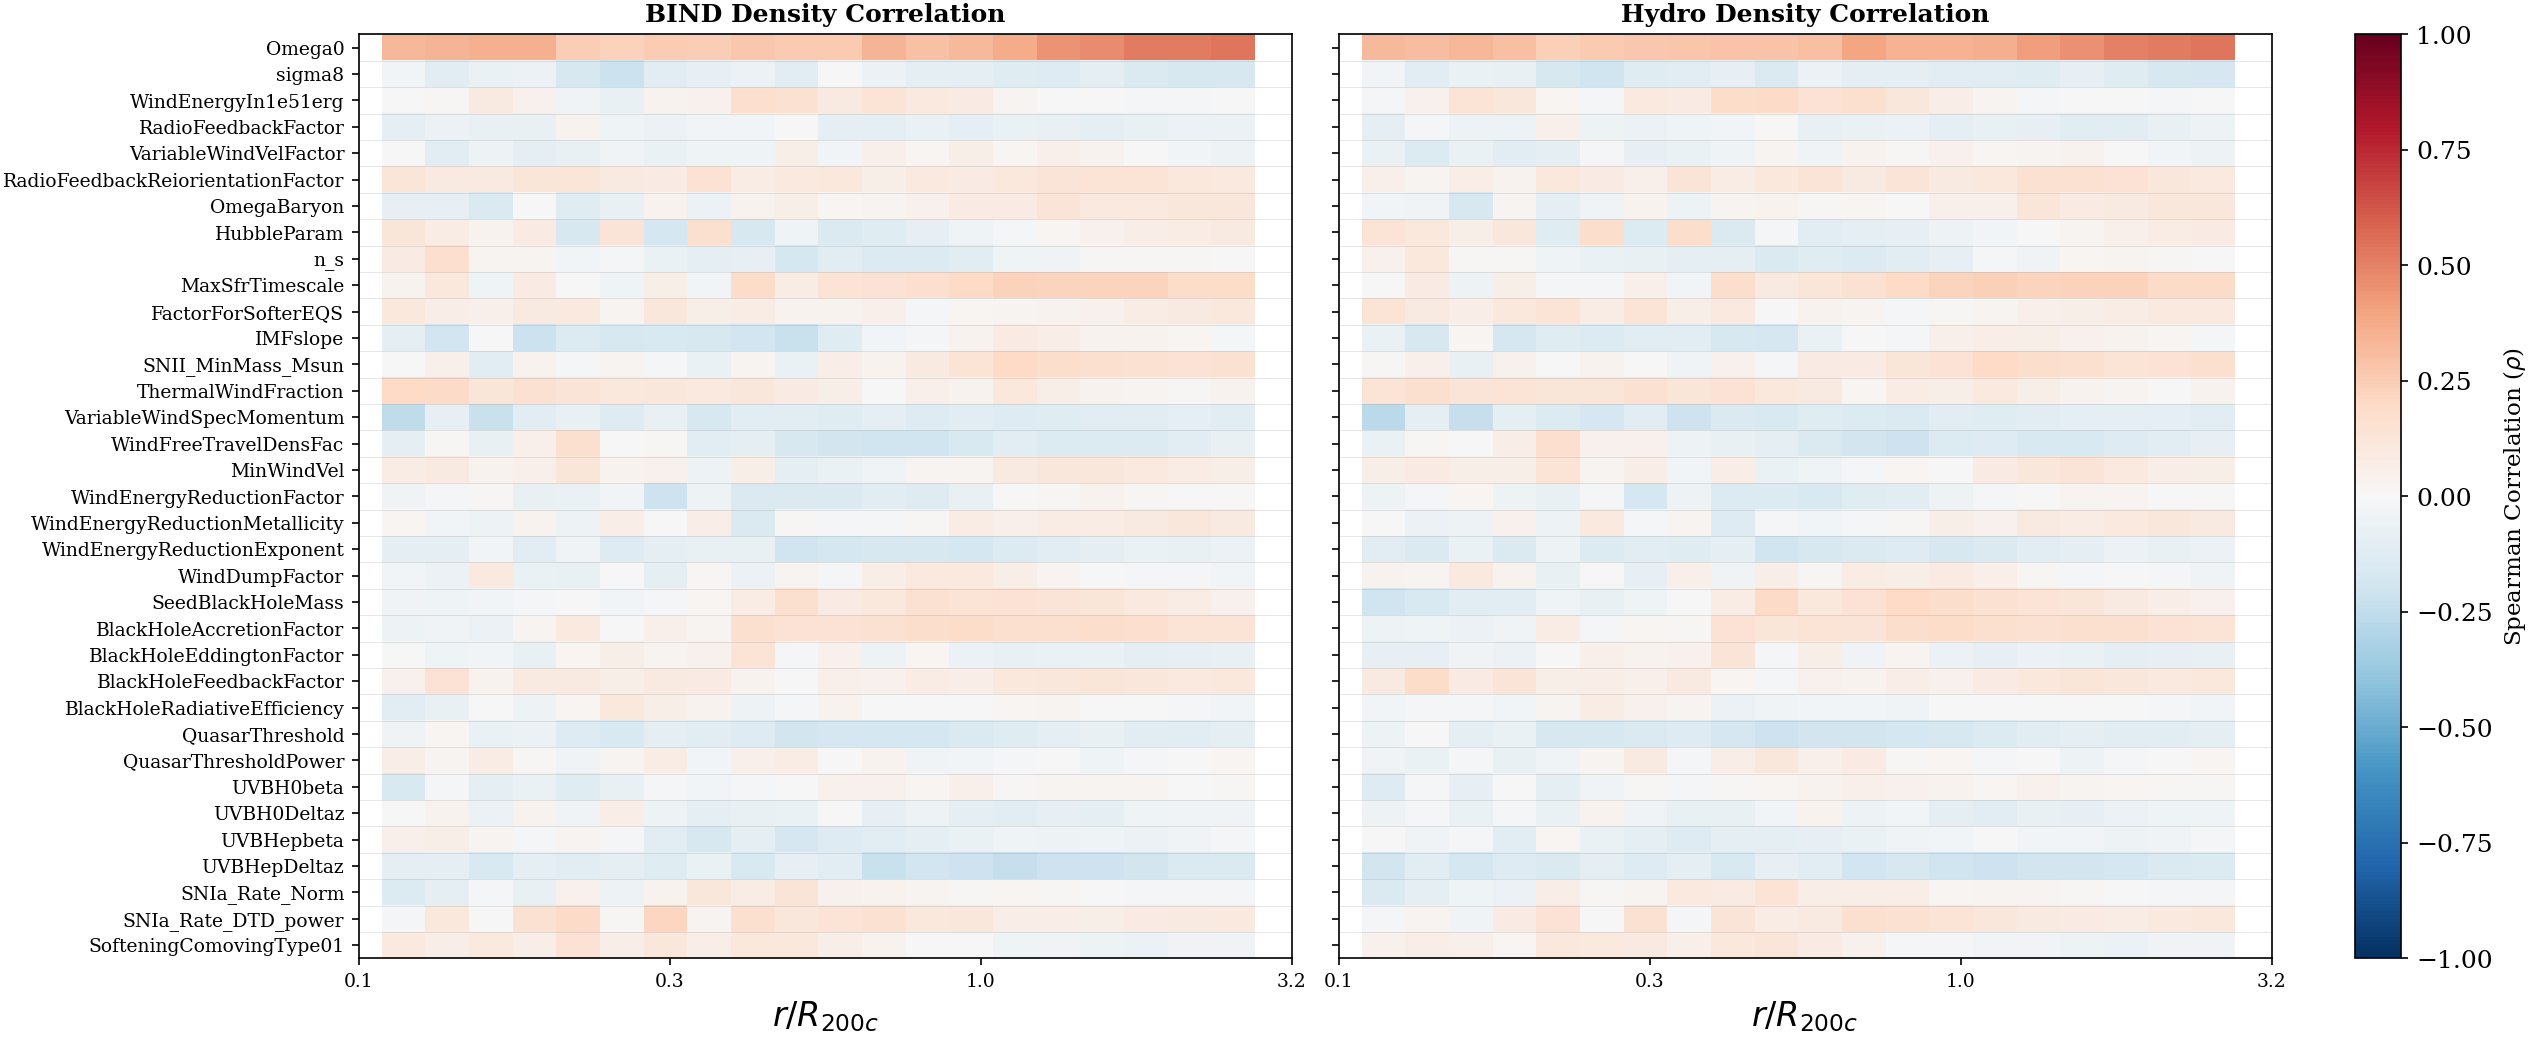

In [16]:
# Figure: Side-by-side correlation heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharey=True, gridspec_kw={'wspace': 0.05})

param_names = [sb35_minmax.loc[i, 'ParamName'] for i in range(35)]
log_radial_bins = np.log10(radial_bins)

# BIND correlations
im1 = ax1.imshow(bind_correlations, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1, origin='lower',
                 extent=[log_radial_bins[0], log_radial_bins[-1], -0.5, 34.5])

ax1.set_yticks(range(35))
ax1.set_yticklabels(param_names, fontsize=9)

for i in range(36):
    ax1.axhline(i - 0.5, color='gray', linewidth=0.3, alpha=0.3)

log_r_ticks = np.array([-1.0, -0.5, 0.0, 0.5])
ax1.set_xticks(log_r_ticks)
ax1.set_xticklabels([f'{10**lr:.1f}' for lr in log_r_ticks], fontsize=9)
ax1.set_xlabel(r'$r/R_{200c}$', fontsize=16)
ax1.set_title('BIND Density Correlation', fontsize=12, fontweight='bold')

# Hydro correlations
im2 = ax2.imshow(hydro_correlations, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1,
                 extent=[log_radial_bins[0], log_radial_bins[-1], 34.5, -0.5])

for i in range(36):
    ax2.axhline(i - 0.5, color='gray', linewidth=0.3, alpha=0.3)

ax2.set_xticks(log_r_ticks)
ax2.set_xticklabels([f'{10**lr:.1f}' for lr in log_r_ticks], fontsize=9)
ax2.set_xlabel(r'$r/R_{200c}$', fontsize=16)
ax2.set_title('Hydro Density Correlation', fontsize=12, fontweight='bold')

# Colorbar
cbar = plt.colorbar(im2, ax=[ax1, ax2], fraction=0.046, pad=0.04)
cbar.set_label(r'Spearman Correlation ($\rho$)', fontsize=11)

savefig_paper(fig, 'density_profile_param_correlation_sidebyside.pdf')
plt.show()

### 6.1 1P Parameter Correlation Analysis

Compute Spearman rank correlations between the varied parameter values and density profiles at each radial bin for the 1P dataset.

In [17]:
# Get 1P parameter names from the params dataframe
oneP_param_names = list(oneP_params.columns[1:-1])  # Exclude first (sim name) and last columns
n_1p_params = len(oneP_param_names)

# Build parameter array for loaded simulations
oneP_param_vals = []
for sim_name in names_1p[:len(oneP_profiles['hydro_profiles'])]:
    try:
        row = oneP_params[oneP_params.iloc[:, 0] == sim_name].iloc[0, 1:-1].values
        oneP_param_vals.append(row)
    except:
        pass

oneP_param_vals = np.array(oneP_param_vals, dtype=float)
print(f"1P Parameters: {oneP_param_names}")
print(f"Parameter array shape: {oneP_param_vals.shape}")

1P Parameters: ['Omega0', 'sigma8', 'WindEnergyIn1e51erg', 'RadioFeedbackFactor', 'VariableWindVelFactor', 'RadioFeedbackReiorientationFactor', 'OmegaBaryon', 'HubbleParam', 'n_s', 'MaxSfrTimescale', 'FactorForSofterEQS', 'IMFslope', 'SNII_MinMass_Msun', 'ThermalWindFraction', 'VariableWindSpecMomentum', 'WindFreeTravelDensFac', 'MinWindVel', 'WindEnergyReductionFactor', 'WindEnergyReductionMetallicity', 'WindEnergyReductionExponent', 'WindDumpFactor', 'SeedBlackHoleMass', 'BlackHoleAccretionFactor', 'BlackHoleEddingtonFactor', 'BlackHoleFeedbackFactor', 'BlackHoleRadiativeEfficiency', 'QuasarThreshold', 'QuasarThresholdPower', 'UVBH0beta', 'UVBH0Deltaz', 'UVBHepbeta', 'UVBHepDeltaz', 'SNIa_Rate_Norm', 'SNIa_Rate_DTD_power', 'SofteningComovingType01']
Parameter array shape: (140, 35)


In [18]:
# Compute Spearman correlations for 1P: density vs parameters
bind_correlations_1p = np.zeros((n_1p_params, len(radial_bins)))
hydro_correlations_1p = np.zeros((n_1p_params, len(radial_bins)))

for param_idx in range(n_1p_params):
    param_values = oneP_param_vals[:, param_idx]
    
    for r_idx in range(len(radial_bins)):
        # BIND densities at this radius
        bind_densities = []
        hydro_densities = []
        
        for sim_idx in range(len(oneP_profiles['hydro_profiles'])):
            bind_prof = oneP_profiles['binded_profiles'][sim_idx][:, r_idx]
            hydro_prof = oneP_profiles['hydro_profiles'][sim_idx][:, r_idx]
            
            valid_bind = bind_prof[np.isfinite(bind_prof)]
            valid_hydro = hydro_prof[np.isfinite(hydro_prof)]
            
            if len(valid_bind) > 0:
                bind_densities.append(np.nanmean(valid_bind))
            else:
                bind_densities.append(np.nan)
                
            if len(valid_hydro) > 0:
                hydro_densities.append(np.nanmean(valid_hydro))
            else:
                hydro_densities.append(np.nan)
        
        bind_densities = np.array(bind_densities)
        hydro_densities = np.array(hydro_densities)
        
        # Compute correlations
        valid_mask = np.isfinite(bind_densities) & np.isfinite(param_values)
        if np.sum(valid_mask) > 3:
            corr, _ = spearmanr(param_values[valid_mask], bind_densities[valid_mask])
            bind_correlations_1p[param_idx, r_idx] = corr
        
        valid_mask = np.isfinite(hydro_densities) & np.isfinite(param_values)
        if np.sum(valid_mask) > 3:
            corr, _ = spearmanr(param_values[valid_mask], hydro_densities[valid_mask])
            hydro_correlations_1p[param_idx, r_idx] = corr

print(f"Computed 1P correlation matrices: {bind_correlations_1p.shape}")

Computed 1P correlation matrices: (35, 20)


### 6.2 1P Channel-wise Parameter Correlation

Compute correlations between parameters and individual channel densities (gas, stellar, dm_hydro).

In [ ]:
# Compute Spearman correlations for 1P by channel: density vs parameters
bind_correlations_1p_bychannel = np.zeros((3, n_1p_params, len(radial_bins)))  # (channel, param, radius)
hydro_correlations_1p_bychannel = np.zeros((3, n_1p_params, len(radial_bins)))

for ch in range(3):  # Loop over channels: dm_hydro, gas, stars
    print(f"Computing correlations for channel {ch} ({CHANNEL_NAMES[ch]})...")
    
    for param_idx in range(n_1p_params):
        param_values = oneP_param_vals[:, param_idx]
        
        for r_idx in range(len(radial_bins)):
            # Collect channel densities at this radius
            bind_densities = []
            hydro_densities = []
            
            for sim_idx in range(len(oneP_profiles['hydro_profiles'])):
                # Load channel-specific data
                sim_name = names_1p[sim_idx]
                
                try:
                    if sim_name.startswith('sim_'):
                        basepath = f'/mnt/home/mlee1/ceph/BIND2d_new/1P/{sim_name}/snap_90/mass_threshold_13/'
                    else:
                        basepath = f'/mnt/home/mlee1/ceph/BIND2d_new/1P/{sim_name}/snap_90/mass_threshold_13/'
                    
                    hydro_cutouts = np.load(basepath + 'hydro_cutouts.npy')
                    halo_metadata = np.load(basepath + 'halo_metadata.npz', allow_pickle=True)
                    halo_radii = halo_metadata['radii']
                    
                    gen_data = np.load(basepath + f'{MODEL_NAME}/generated_halos.npz')
                    gen_cutouts = gen_data['generated']
                    n_batch = gen_cutouts.shape[1]
                    
                    # Compute average density at this radius across all halos in this sim
                    sim_bind_vals = []
                    sim_hydro_vals = []
                    
                    for halo_idx in range(len(hydro_cutouts)):
                        radius_pix = radius_kpc_to_pixels(halo_radii[halo_idx])
                        
                        # Hydro channel profile
                        hydro_channel = hydro_cutouts[halo_idx, ch]
                        hydro_profile, _ = get_projected_surface_density(hydro_channel, radius_pix)
                        if np.isfinite(hydro_profile[r_idx]):
                            sim_hydro_vals.append(hydro_profile[r_idx])
                        
                        # BIND channel profile - average across batch
                        batch_vals = []
                        for b in range(n_batch):
                            binded_channel = gen_cutouts[halo_idx, b, ch]
                            binded_profile, _ = get_projected_surface_density(binded_channel, radius_pix)
                            if np.isfinite(binded_profile[r_idx]):
                                batch_vals.append(binded_profile[r_idx])
                        
                        if len(batch_vals) > 0:
                            sim_bind_vals.append(np.mean(batch_vals))
                    
                    # Store mean across halos for this simulation
                    if len(sim_bind_vals) > 0:
                        bind_densities.append(np.mean(sim_bind_vals))
                    else:
                        bind_densities.append(np.nan)
                    
                    if len(sim_hydro_vals) > 0:
                        hydro_densities.append(np.mean(sim_hydro_vals))
                    else:
                        hydro_densities.append(np.nan)
                        
                except Exception as e:
                    bind_densities.append(np.nan)
                    hydro_densities.append(np.nan)
            
            bind_densities = np.array(bind_densities)
            hydro_densities = np.array(hydro_densities)
            
            # Compute correlations
            valid_mask = np.isfinite(bind_densities) & np.isfinite(param_values)
            if np.sum(valid_mask) > 3:
                corr, _ = spearmanr(param_values[valid_mask], bind_densities[valid_mask])
                bind_correlations_1p_bychannel[ch, param_idx, r_idx] = corr
            
            valid_mask = np.isfinite(hydro_densities) & np.isfinite(param_values)
            if np.sum(valid_mask) > 3:
                corr, _ = spearmanr(param_values[valid_mask], hydro_densities[valid_mask])
                hydro_correlations_1p_bychannel[ch, param_idx, r_idx] = corr

print(f"\nComputed 1P channel-wise correlation matrices: {bind_correlations_1p_bychannel.shape}")
print("Shape: (channels, parameters, radial_bins)")

Computing correlations for channel 0 (Hydro DM)...


In [ ]:
# Figure: Channel-wise correlation heatmaps for 1P dataset (3 rows x 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(18, 14), sharey=True, sharex=True, 
                         gridspec_kw={'wspace': 0.05, 'hspace': 0.15})

log_radial_bins = np.log10(radial_bins)

for ch_idx, ch_name in enumerate(CHANNEL_NAMES):
    ax_bind = axes[ch_idx, 0]
    ax_hydro = axes[ch_idx, 1]
    
    # BIND correlations for this channel
    im1 = ax_bind.imshow(bind_correlations_1p_bychannel[ch_idx], aspect='auto', cmap='RdBu_r', 
                         vmin=-1, vmax=1, origin='lower',
                         extent=[log_radial_bins[0], log_radial_bins[-1], -0.5, n_1p_params - 0.5])
    
    if ch_idx == 0:
        ax_bind.set_title('BIND Density Correlation', fontsize=14, fontweight='bold')
    
    # Hydro correlations for this channel
    im2 = ax_hydro.imshow(hydro_correlations_1p_bychannel[ch_idx], aspect='auto', cmap='RdBu_r',
                          vmin=-1, vmax=1, origin='lower',
                          extent=[log_radial_bins[0], log_radial_bins[-1], -0.5, n_1p_params - 0.5])
    
    if ch_idx == 0:
        ax_hydro.set_title('Hydro Density Correlation', fontsize=14, fontweight='bold')
    
    # Y-axis labels (only leftmost column)
    if ch_idx == 0:
        ax_bind.set_yticks(range(n_1p_params))
        ax_bind.set_yticklabels(oneP_param_names, fontsize=9)
    
    # Gridlines
    for i in range(n_1p_params + 1):
        ax_bind.axhline(i - 0.5, color='gray', linewidth=0.3, alpha=0.3)
        ax_hydro.axhline(i - 0.5, color='gray', linewidth=0.3, alpha=0.3)
    
    # X-axis labels (only bottom row)
    if ch_idx == 2:
        log_r_ticks = np.array([-1.0, -0.5, 0.0, 0.5])
        ax_bind.set_xticks(log_r_ticks)
        ax_bind.set_xticklabels([f'{10**lr:.1f}' for lr in log_r_ticks], fontsize=10)
        ax_bind.set_xlabel(r'$r/R_{200c}$', fontsize=14)
        
        ax_hydro.set_xticks(log_r_ticks)
        ax_hydro.set_xticklabels([f'{10**lr:.1f}' for lr in log_r_ticks], fontsize=10)
        ax_hydro.set_xlabel(r'$r/R_{200c}$', fontsize=14)
    
    # Channel label on the left
    ax_bind.text(-0.25, 0.5, ch_name, transform=ax_bind.transAxes, fontsize=16, 
                 fontweight='bold', verticalalignment='center', horizontalalignment='center',
                 rotation=90)

# Colorbar
cbar = plt.colorbar(im2, ax=axes, fraction=0.03, pad=0.02)
cbar.set_label(r'Spearman Correlation ($\rho$)', fontsize=12)

plt.tight_layout()
savefig_paper(fig, 'density_profile_param_correlation_bychannel_1P.pdf')
plt.show()

/tmp/ipykernel_1063212/965681896.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


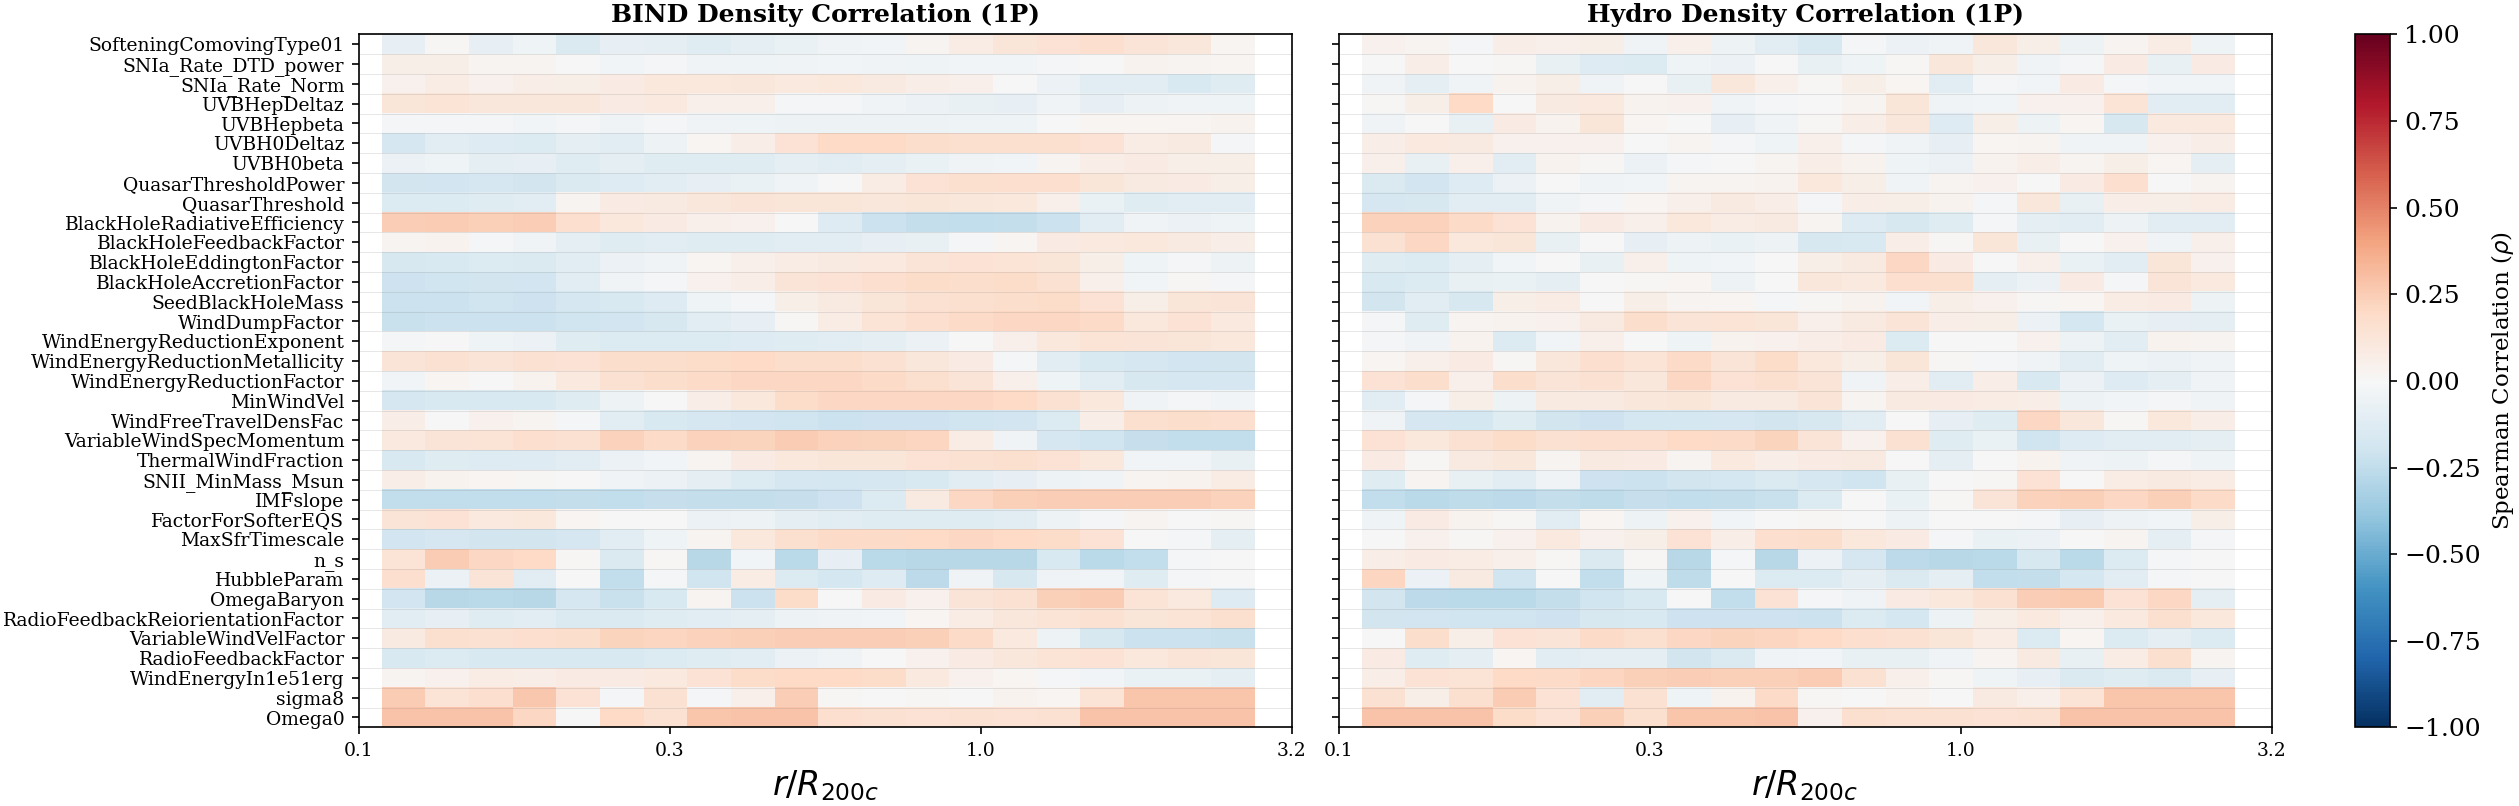

In [19]:
# Figure: Side-by-side correlation heatmaps for 1P dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True, gridspec_kw={'wspace': 0.05})

log_radial_bins = np.log10(radial_bins)

# BIND correlations
im1 = ax1.imshow(bind_correlations_1p, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1, origin='lower',
                 extent=[log_radial_bins[0], log_radial_bins[-1], -0.5, n_1p_params - 0.5])

ax1.set_yticks(range(n_1p_params))
ax1.set_yticklabels(oneP_param_names, fontsize=9)

for i in range(n_1p_params + 1):
    ax1.axhline(i - 0.5, color='gray', linewidth=0.3, alpha=0.3)

log_r_ticks = np.array([-1.0, -0.5, 0.0, 0.5])
ax1.set_xticks(log_r_ticks)
ax1.set_xticklabels([f'{10**lr:.1f}' for lr in log_r_ticks], fontsize=9)
ax1.set_xlabel(r'$r/R_{200c}$', fontsize=16)
ax1.set_title('BIND Density Correlation (1P)', fontsize=12, fontweight='bold')

# Hydro correlations
im2 = ax2.imshow(hydro_correlations_1p, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1, origin='lower',
                 extent=[log_radial_bins[0], log_radial_bins[-1], -0.5, n_1p_params - 0.5])

for i in range(n_1p_params + 1):
    ax2.axhline(i - 0.5, color='gray', linewidth=0.3, alpha=0.3)

ax2.set_xticks(log_r_ticks)
ax2.set_xticklabels([f'{10**lr:.1f}' for lr in log_r_ticks], fontsize=9)
ax2.set_xlabel(r'$r/R_{200c}$', fontsize=16)
ax2.set_title('Hydro Density Correlation (1P)', fontsize=12, fontweight='bold')

# Colorbar
cbar = plt.colorbar(im2, ax=[ax1, ax2], fraction=0.046, pad=0.04)
cbar.set_label(r'Spearman Correlation ($\rho$)', fontsize=11)

plt.tight_layout()
savefig_paper(fig, 'density_profile_param_correlation_sidebyside_1P.pdf')
plt.show()

---

## Summary

This notebook analyzed radial density profiles comparing BIND-generated halos to true hydrodynamic halos:

1. **Mean Residuals**: BIND achieves ~5-10% accuracy in reproducing total surface density profiles
2. **Channel-wise**: Gas and stellar components show larger residuals than dark matter
3. **Parameter Dependence**: Similar correlation patterns between BIND and hydro suggest BIND captures physics correctly

**Key finding:** Residuals are generally small within $R_{200c}$ but increase in the outskirts, likely due to lower signal-to-noise and more complex environmental effects.

**Next:** See `04_integrated_mass_analysis.ipynb` for total mass within virial radii.